# Full-waveform inversion using Forge

In this notebook we apply full-waveform inversion (FWI) to a small, simple demo model. FWI is a high-resolution data-intensive tomographic imaging method, originally developed in geophysics for imaging the subsurface. 

By default, Forge will automatically attempt to run the forward modelling and inversion on the GPU. If a suitably configured cuda-enabled GPU is not available, it will revert to the CPU. The problem presented here is intentially small enough so that this is not an issue. 

### Contents

1. Model definition
2. Acquisition setup
3. Forward modelling
4. Optimization

## 1. Model definition

In [1]:
# Choose the frequency (in Hz) of the source wavelet and the acoustic velocities of the model
frequency = 2e5
min_vel = 1480
med_vel = 1520
max_vel = 1620

Set the spatial increment, `dx`, to be small enough to sufficiently mitigate numerical dispersion by ensuring there are a 6 grid-points per wavelength.

In [2]:
min_wavelength = min_vel/frequency
dx = min_wavelength/6
print(f'spatial increment dx: {dx:.3g}')

spatial increment dx: 0.00123


Set the temporal increment, `dt`, to be small enough to meet the CFL condition for numerical stability. 

In [3]:
courant_num = 0.61 
dt = (courant_num*dx)/max_vel
print(f'temporal increment dt: {dt:.3g}')

temporal increment dt: 4.64e-07


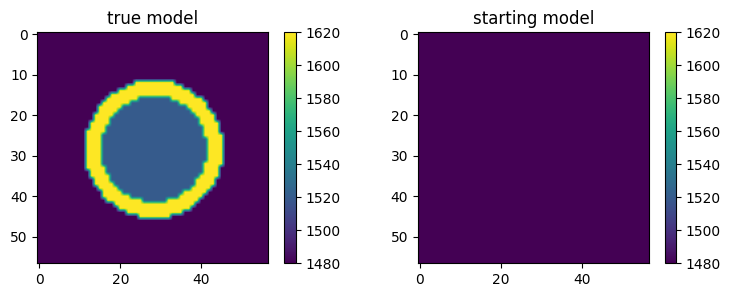

In [4]:
from utils import demo_model

# Define the true model, m, and the inversion starting model m0
m, m0 = demo_model(dx, min_vel, med_vel, max_vel, plot=True)

## 2. Acquisition setup

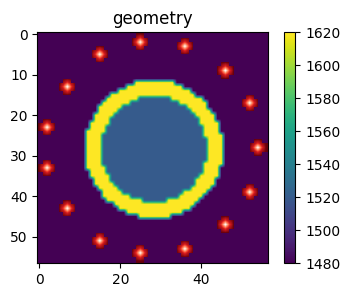

In [5]:
from utils import demo_geometry

# Define the receiver and source geometry in terms of their grid cell positions
r_pos = demo_geometry(m, n_elements=15, plot=True)
s_pos = r_pos.copy()

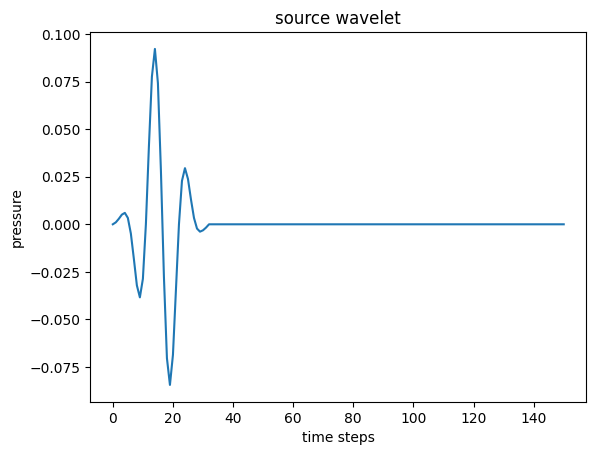

In [6]:
from forge.utils import tone_burst

time = 0.00007  # Maximum time in seconds
amplitude = 1e-1  #  Maximum source pressure 
num = round(time/dt) #  Number of time-steps
num_cycles = 3  # Use a 3 cycle tone-burst

# Define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num, amplitude, plot=True)

## 3. Forward modelling

Generate synthetic "target" acoustic data using the acquisition setup and true model that have been defined. In a real-world scenario, this will be data obtained from an ultrasound acquisition system.

In [7]:
from forge.model import FullWaveformInversion

# Instantiate a FullWaveformInversion class to run the forward modelling
true_model = FullWaveformInversion(model = m,  # True model
                                   dx = dx,  # Spatial increment
                                   dt = dt,  # Temporal increment
                                   r_pos = r_pos)  # Receiver positions

device = cuda:0


In [8]:
# Forward modelling using the source wavelet at the source positions
true_model.forward(s_pos, source)

forward modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 349.15it/s]


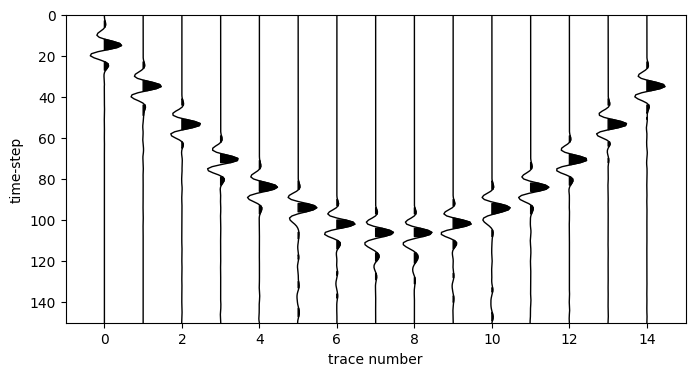

In [9]:
from forge.utils import trace_plot, normalize

# Visualize traces of true modelled data
trace_plot(normalize(true_model.d), 0)

In [10]:
from pyslice import slicer, render

shot=0
wavefield = true_model.wavefield.cpu()[shot]
scale = wavefield.abs().max()/3

# Animate second partial derivative of the wavefield w.r.t time, scaled by the acoustic velocity model
ani = slicer(wavefield,
             animate=True,
             vmin=-scale,
             vmax=scale,
             cmap='seismic',
             title='Second wavefield derivative')
render(ani)

## 4. Inversion

In [11]:
# Instantiate a new FullWaveformInversion class for the inversion
model = FullWaveformInversion(model = m0,  # Starting model
                              dx = dx,  # Spatial increment
                              dt = dt,  # Temporal increment
                              r_pos = r_pos)  # Receiver positions

device = cuda:0


### Optimizers

PyTorch contains a suite of optimizers that can be selected and tuned accordingly.

In [12]:
import torch

# Define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

### Loss function

We can select a PyTorch loss function that suites our purpose. Or we may wish to build our own custom loss function using PyTorch functions.

In [13]:
l2_loss = torch.nn.MSELoss()

# Uncomment to test a custom trace-normalized L2 loss function
#def l2_loss(input, target):
#    return torch.norm(normalize(input) - normalize(target))**2

### Callbacks

A default optimization loop can be executed with `.fit()`. For ease and flexible customization, an arbitrary number of callback functions can be defined to act on:
1. the adjoint source prior to back-propagation and/or
2. the model gradient and/or parameters prior to taking an optimization step.

For example, these could be regularization terms, filters, or plotting functions to visualize adjoint sources or gradients.

In [14]:
from scipy.ndimage import gaussian_filter
from forge.filters import butter_filter

# Define a Gaussian smoothing callback function for the model gradient
def grad_smoothing(m, sigma=0.1):
    m.grad[model.bp:-model.bp, model.bp:-model.bp] = torch.from_numpy(
                gaussian_filter(m.grad.cpu()[model.bp:-model.bp, model.bp:-model.bp], sigma))

# Define a function to low pass filter the adjoint source
def low_pass(adjoint_source):
    adjoint_source = torch.from_numpy(butter_filter(adjoint_source, 4e5, 1/dt, order=12)).float()

In [15]:
# Invert the data with .fit()
model.fit(data = true_model.d,  # True data
          s_pos = s_pos,  # Source locations in grid-cells
          source = source,  # Source wavelet
          optimizer = opt,  # Optimizer
          loss = l2_loss,  # Loss function
          num_iter = 10,  # Number of iterations per frequency block
          bs = 10,  # Batch size/number of sources per forward run
          blocks = [1e5, 2e5],  # Multi-scale frequency blocks
          model_callbacks = [grad_smoothing],  # Apply model/gradient callbacks before the optimization step
          adjoint_callbacks = [low_pass],  # Apply adjoint source callbacks before back-propagation
          box = (min_vel, max_vel),  # Box constraints
          true_model = m)  # True model for reporting inversion RMSE

2024-04-26 14:31:43  block 1/2    1e+05Hz
2024-04-26 14:31:43    iteration 1/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 406.03it/s]


2024-04-26 14:31:44      loss = 8.731e-15
2024-04-26 14:31:44      rmse = 0.01329
2024-04-26 14:31:44    iteration 2/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 402.01it/s]


2024-04-26 14:31:44      loss = 4.119e-15
2024-04-26 14:31:44      rmse = 0.01077
2024-04-26 14:31:44    iteration 3/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 395.71it/s]


2024-04-26 14:31:45      loss = 1.702e-15
2024-04-26 14:31:45      rmse = 0.008838
2024-04-26 14:31:45    iteration 4/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 391.32it/s]


2024-04-26 14:31:46      loss = 6.492e-16
2024-04-26 14:31:46      rmse = 0.007722
2024-04-26 14:31:46    iteration 5/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 397.83it/s]


2024-04-26 14:31:47      loss = 2.853e-16
2024-04-26 14:31:47      rmse = 0.006381
2024-04-26 14:31:47    iteration 6/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 409.43it/s]


2024-04-26 14:31:48      loss = 1.266e-16
2024-04-26 14:31:48      rmse = 0.005594
2024-04-26 14:31:48    iteration 7/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 413.80it/s]


2024-04-26 14:31:48      loss = 1.104e-16
2024-04-26 14:31:48      rmse = 0.00526
2024-04-26 14:31:48    iteration 8/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 414.48it/s]


2024-04-26 14:31:49      loss = 4.343e-17
2024-04-26 14:31:49      rmse = 0.00487
2024-04-26 14:31:49    iteration 9/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 406.75it/s]


2024-04-26 14:31:50      loss = 5.945e-17
2024-04-26 14:31:50      rmse = 0.004761
2024-04-26 14:31:50    iteration 10/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 393.75it/s]


2024-04-26 14:31:51      loss = 3.477e-17
2024-04-26 14:31:51      rmse = 0.004582
_______________________________________________________ 

2024-04-26 14:31:51  block 2/2    2e+05Hz
2024-04-26 14:31:51    iteration 1/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 371.63it/s]


2024-04-26 14:31:51      loss = 1.443e-14
2024-04-26 14:31:51      rmse = 0.004419
2024-04-26 14:31:51    iteration 2/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 378.96it/s]


2024-04-26 14:31:52      loss = 3.719e-15
2024-04-26 14:31:52      rmse = 0.004171
2024-04-26 14:31:52    iteration 3/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 391.01it/s]


2024-04-26 14:31:53      loss = 3.058e-15
2024-04-26 14:31:53      rmse = 0.004012
2024-04-26 14:31:53    iteration 4/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 345.87it/s]


2024-04-26 14:31:54      loss = 1.744e-15
2024-04-26 14:31:54      rmse = 0.003864
2024-04-26 14:31:54    iteration 5/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 402.47it/s]


2024-04-26 14:31:55      loss = 3.195e-15
2024-04-26 14:31:55      rmse = 0.003852
2024-04-26 14:31:55    iteration 6/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 412.24it/s]


2024-04-26 14:31:55      loss = 4.965e-15
2024-04-26 14:31:55      rmse = 0.003812
2024-04-26 14:31:55    iteration 7/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 387.59it/s]


2024-04-26 14:31:56      loss = 1.676e-14
2024-04-26 14:31:56      rmse = 0.003646
2024-04-26 14:31:56    iteration 8/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 388.36it/s]


2024-04-26 14:31:57      loss = 3.262e-15
2024-04-26 14:31:57      rmse = 0.003779
2024-04-26 14:31:57    iteration 9/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 395.77it/s]


2024-04-26 14:31:58      loss = 7.679e-15
2024-04-26 14:31:58      rmse = 0.003599
2024-04-26 14:31:58    iteration 10/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 403.83it/s]

2024-04-26 14:31:59      loss = 6.808e-15
2024-04-26 14:31:59      rmse = 0.003532
_______________________________________________________ 



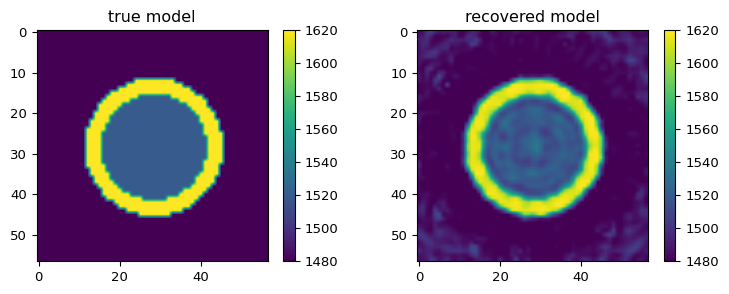

In [16]:
import matplotlib.pyplot as plt

# Compare the true vs the FWI recovered model
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(m, vmin=min_vel, vmax=max_vel, interpolation='bilinear')
plt.title('true model')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(model.get_model(), vmin=min_vel, vmax=max_vel, interpolation='bilinear')
plt.title('recovered model')
plt.colorbar()
plt.show()

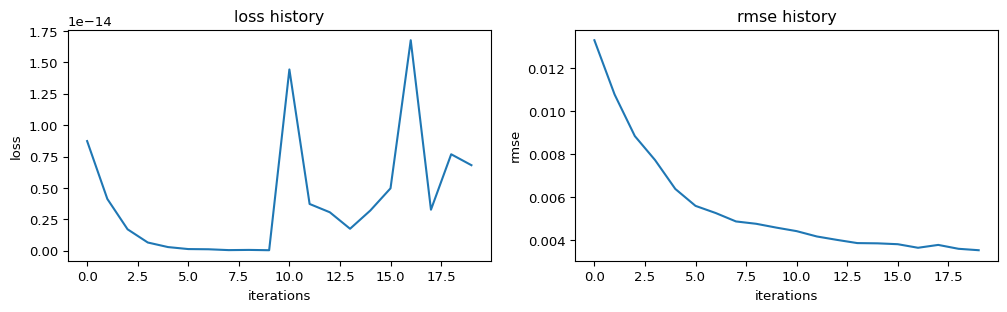

In [17]:
# View the inversion metrics
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(model.loss_history)
plt.title('loss history')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(model.rmse_history)
plt.title('rmse history')
plt.xlabel('iterations')
plt.ylabel('rmse')
plt.show()